In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
colwidth = 3.41667
fs = 10
mpl.rcParams.update({'font.size': fs, 
                     "text.usetex":  True, 
                     'font.family':'serif',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize':8 })

fig_kwargs = {'dpi':800, 'bbox_inches': 'tight'}

# Gaussian states and operations

In [2]:
from bosonicplus.base import State
import numpy as np

state = State()

x =np.linspace(-8,8,300)
Wvac = state.get_wigner_log(x,x)
num_weights_vac = state.num_weights

#Generate a squeezed state
from bosonicplus.operations.symplectic import squeezing
r = 1
phi = 0
state.apply_symplectic(squeezing(r, phi))
Wsq = state.get_wigner_log(x,x)
num_weights_sq= state.num_weights

#Generate a coherent state
state = State()
alpha = 0.5+1j
disp = np.sqrt(2*state.hbar)*np.array([alpha.real, alpha.imag])
state.apply_displacement(disp)

Wdisp = state.get_wigner_log(x,x)
num_weights_disp = state.num_weights


# Preparing a Fock state with a small GBS circuit

In [3]:
from bosonicplus.operations.symplectic import beam_splitter

def herald_fock(r, n, eta, infid = 1e-4):
    #Make an EPR pair
    state = State(2)
    state.apply_symplectic_fast(squeezing(r, 0), [0]) #Squeeze mode 1 in x
    state.apply_symplectic_fast(squeezing(r, np.pi), [1]) #Squeeze mode 2 in p
    
    theta = np.pi/4
    state.apply_symplectic(beam_splitter(theta,0)) #50:50 beamsplitter

    #Loss channel
    etas = np.array([1,eta]) #transmissivities of loss channel in each mode
    nbars = np.zeros(2) #thermal photon numbers
    state.apply_loss(etas, nbars) #apply the loss channel
    
    state.post_select_fock_coherent(1, n, inf = infid) #project mode 2 on Fock n
    return state

r = 1
n = 10 #photon number
eta = 1 #quantum efficiency of photon detector
state = herald_fock(r, n, eta)

Wfock = state.get_wigner_log(x,x)
num_weights_fock = state.num_weights
print('Heralding prob', state.norm)
def prob_fock(r,n):
    return np.tanh(r)**(2*n)/np.cosh(r)**2
    
print('Analytical prob', prob_fock(r,n))

Heralding prob 0.0018098871490445667
Analytical prob 0.001810067685313628


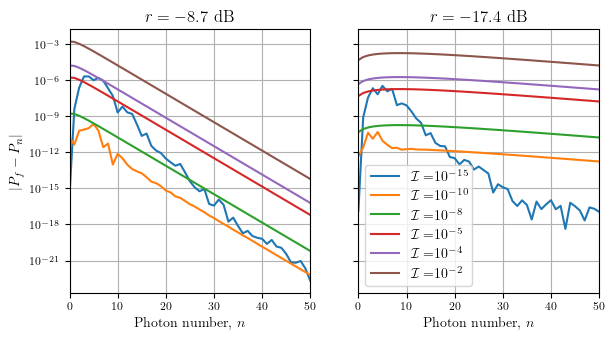

In [4]:
from bosonicplus.conversions import r_to_dB
fig, ax  = plt.subplots(1,2, figsize = (2*colwidth,colwidth), sharey=True, sharex=True)

infids = np.array([1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-2])
ns = np.arange(51)

rs = np.array([1,2])
prob_diff = np.zeros((len(rs), len(infids), len(ns)))

for i,r in enumerate(rs):
    for j, inf in enumerate(infids):
        for k, n in enumerate(ns):
            prob = herald_fock(r, n, 1, inf).norm
            prob_diff[i,j,k] = np.abs(prob_fock(r,n) - prob)

        ax[i].plot(ns, prob_diff[i,j,:], label = r'$\mathcal{I}=$'+r'$10^{{{:d}}}$'.format(int(np.log10(inf))))
    ax[i].set_yscale('log')
    ax[i].grid('on')    

    ax[i].set_xlabel(r'Photon number, $n$')
    ax[i].set_xlim([0,max(ns)])
    ax[i].set_title(rf'$r={np.round(r_to_dB(r),1)}$ dB')

ax[0].set_ylabel(r'$|P_{f}-P_{n}|$')
ax[1].legend()
#fig.savefig("thesis_figures/Fock_prob_accuracy.pdf", **fig_kwargs)
plt.show()



In [5]:
from bosonicplus.plotting import plot_wig, plot_wigner_marginals
from bosonicplus.conversions import r_to_dB

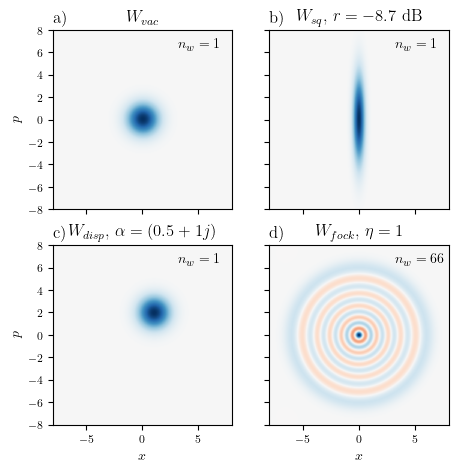

In [6]:
fig, axes = plt.subplots(2,2, figsize = (colwidth*3/2,3/2*colwidth), sharex =True, sharey=True)
plot_wig(Wvac,x,x, ax = axes[0,0], colorbar = False)
plot_wig(Wsq,x,x, ax = axes[0,1], colorbar = False)
plot_wig(Wdisp,x,x,ax = axes[1,0], colorbar=False)
plot_wig(Wfock.real,x,x,ax = axes[1,1], colorbar=False)

def annotate_plot(title, label, num_weights, ax):
   
    ax.text(0.7,0.9,rf'$n_w={num_weights}$',transform=ax.transAxes)
    ax.set_title(title)
    ax.set_title(label, loc='left')


annotate_plot(r'$W_{vac}$', 'a)', num_weights_vac, axes[0,0])
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,1].set_ylabel('')
axes[0,1].set_ylabel('')
annotate_plot(r'$W_{sq},$ '+rf'$r={np.round(r_to_dB(1),1)}$ dB', 'b)', num_weights_sq, axes[0,1])
annotate_plot(r'$W_{disp},$ '+rf'$\alpha={alpha}$', 'c)', num_weights_disp, axes[1,0])
annotate_plot(r'$W_{fock},$ '+rf'$\eta={eta}$', 'd)', num_weights_fock, axes[1,1])
    

#plt.savefig('thesis_figures/Basics.pdf',**fig_kwargs)
plt.show()

## Preparing a Fock state with pseudo-PNRD

In [7]:
def herald_fock_ppnrd(r, n, M):
    state = State(2)
    state.apply_symplectic_fast(squeezing(r, 0), [0]) #Squeeze mode 1 in x
    state.apply_symplectic_fast(squeezing(r, np.pi), [1]) #Squeeze mode 2 in p
    theta = np.pi/4
    state.apply_symplectic(beam_splitter(theta,0)) #50:50 beamsplitter

    #Post select using pseudo pnrd
    state.post_select_ppnrd_thermal(1, n, M) #project mode 2 on Fock n
    return state

r = 1
theta = np.pi/4
n = 10 #photon number
M = 20 #number of on/off detectors

state_ppnrd = herald_fock_ppnrd(r, n, M)
x = np.linspace(-10,10,300)
Wfock_ppnrd = state_ppnrd.get_wigner_log(x,x)
num_weights_ppnrd = state_ppnrd.num_weights
print('Heralding prob', state_ppnrd.norm)

Heralding prob (0.0007078111213545169+5.7068549531787926e-09j)


Heralding prob 0.0007544042233843301


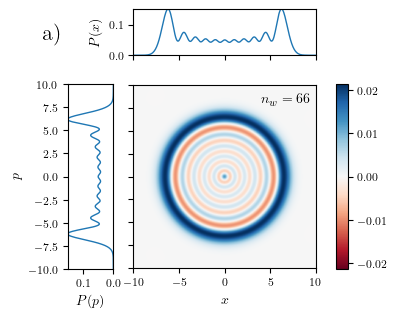

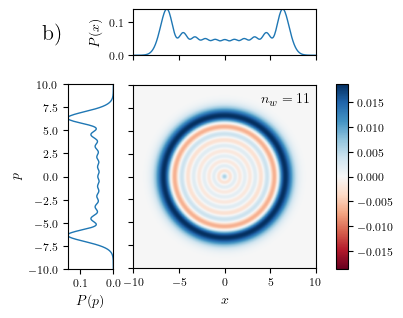

Numerical interation over W_loss (0.9999996194635407-13.884186063044316j)
Numerical interation over W_ppnrd (0.9999805926664436+1.564751302481644e-10j)
Overlap betwen state_ppnrd and state_loss (0.20932777293670388+0.20070260988135546j)
Overlap betwen state_ppnrd and state_loss (0.20916833212357788+0.2005029349544537j)
Overlap between W_ppnrd and W_loss using numerical integraction (0.2093324461369418+0.20076636973734358j)


In [8]:
state_loss = herald_fock(r, n, 0.8)
Wfock_loss = state_loss.get_wigner_log(x,x)
print('Heralding prob', state_loss.norm)


#fig, axes = plt.subplots(1,2, figsize = (colwidth*2, colwidth), sharex =True, sharey=True)
fig, ax, axx, axp, axc = plot_wigner_marginals(Wfock_loss.real,x,x)
ax.text(0.7,0.9, rf'$n_w={state_loss.num_weights}$',transform=ax.transAxes)
ax.text(-0.5, 1.25, r'a)', fontsize = 16, transform=ax.transAxes)
#fig.savefig('thesis_figures/W_fock_loss.pdf', **fig_kwargs)

plt.show()

fig, ax, axx, axp, axc = plot_wigner_marginals(Wfock_ppnrd.real,x,x)
ax.text(0.7,0.9,rf'$n_w={state_ppnrd.num_weights}$',transform=ax.transAxes)
ax.text(-0.5, 1.25, r'b)', fontsize = 16, transform=ax.transAxes)
#fig.savefig('thesis_figures/W_fock_ppnrd.pdf', **fig_kwargs)
plt.show()

print('Numerical interation over W_loss', np.sum(Wfock_loss*np.diff(x)[-1]**2))
print('Numerical interation over W_ppnrd', np.sum(Wfock_ppnrd*np.diff(x)[-1]**2))

from bosonicplus.fidelity import overlap_bosonic, overlap_log, overlap_with_wigner
from bosonicplus.states.nongauss import prepare_fock_coherent

print('Overlap betwen state_ppnrd and state_loss', overlap_bosonic(state_ppnrd, state_loss))
print('Overlap betwen state_ppnrd and state_loss', overlap_log(state_ppnrd, state_loss))

print('Overlap between W_ppnrd and W_loss using numerical integraction', overlap_with_wigner(Wfock_loss, Wfock_ppnrd, x, x))

#Because state_loss is in the fast rep, the real part of the results must always be taken.

inf = 1e-05
x_4 0.4687400519998366
y_4 0.47742816315811465
inf = 1e-06
x_4 0.46873741015460546
y_4 0.47743383570442705
inf = 1e-09
x_4 0.46873666387877455
y_4 0.47743494677150483


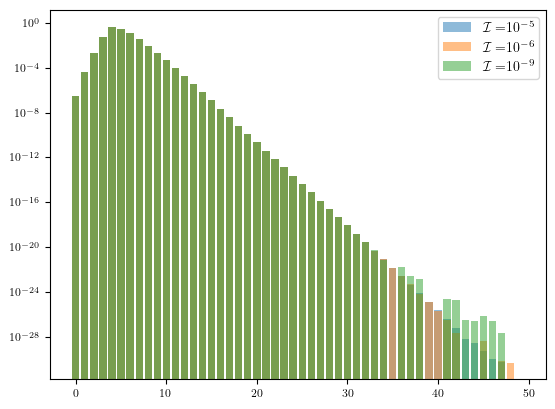

In [9]:
#Calculating photon number probabilities
#Comparing with Fig. 2 in Provaznik et al. https://doi.org/10.48550/arXiv.2506.01171
from bosonicplus.conversions import dB_to_r

n = 4
state= herald_fock(dB_to_r(-10), n, 0.8, infid = 1e-5) #20% loss on heralding
state.apply_loss(np.array([1-0.0275]),np.zeros(1)) #2.75% loss on characterisation

from bosonicplus.states.nongauss import prepare_fock_coherent
def get_photon_number_prob(state, n, inf = 1e-10):
    fock = prepare_fock_coherent(n, inf)
    return overlap_log(fock, state)

infids = np.array([1e-5, 1e-6, 1e-9])
ns = np.arange(50)

for inf in infids:
    probs = np.zeros(len(ns))
    for i, m in enumerate(ns):
        probs[i] = get_photon_number_prob(state, m, inf).real 
    
    plt.bar(ns, probs, alpha = 0.5, label = r'$\mathcal{I}=$'+r'$10^{{{:d}}}$'.format(int(np.log10(inf))))    
    print(f'inf = {inf}')
    print(f'x_{n}', 1-np.sum(probs[0:n+1]))   
    print(f'y_{n}', probs[n])
plt.legend()
plt.yscale('log')